In [1]:
import time
import copy as cp

import numpy as np
from numba import jit, njit
PI = np.pi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
plt.rcParams['image.cmap']='cool'  ## set a global cmap: 'cool' ,   'twilight_shifted', 'hsv', 'jet'
cmap = 'cool'
alpha = 0.9


In [2]:
def plot_2D(f, x_label = '$x$', y_label = '$y$', title='$f(x,y)$'):
    
    fig, ax = plt.subplots(figsize = (6, 10))
    ax.imshow(f, cmap='cool', origin='lower')
    ax.set_xlabel(x_label, fontsize=15);
    ax.set_ylabel(y_label, fontsize=15);
    ax.set_title(title, fontsize = 20) ;
    plt.show()


def plot_3D(x,y,z, x_label = '$x$', y_label ='$y$', z_label = '$z$', title='$f(x,y)$', elev=15., azim=0):  
    
    fig = plt.figure( figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap = cmap, alpha = alpha)
    ax.set_xlabel(x_label, fontsize=15);
    ax.set_ylabel(y_label, fontsize=15);
    ax.set_zlabel(z_label, fontsize=15);
    ax.set_title(title, fontsize = 20);
    ax.view_init(elev=elev, azim=azim)
    plt.show()

## Partial differential equations - wave-type equations

Scheme: 
1. Discretize the spatial dimention: $u_n=u(x_n,t)$  (for example $x_n=nh$) 

2. write a system of $N$ second order (or $2N$ first order) time differential equations:
$$\partial_{tt}u_n=D_{nm}u_m-F_n$$


* write a system of $𝑁$ second order equations:

    $$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

    $$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}, \qquad n,m = 0,1,2,3,..., N-1$$
    

* write a system of $2 𝑁$ first order equations:

$$ \vec{v}=(u, \partial_x u)$$

$$ \partial_x \vec{v}=(\partial_x u, \partial_{xx} u)$$

$$ u'_n=\frac{u_{n+1}-u_{n-1}}{2h}$$

$$D_{n,m} = ? , \qquad n,m = 0,1,2,3,..., 2N-1$$


3. use some time-stepping method to solve the system for given initial conditions $u(x, 0), \partial_t u(x, 0)$ and boundary conditions, such as $u(0,t)=f(x)$ and $u(L,t)=g(x)$.
* Runge-Kutta method
* simplectic method

4. Important issue: stability.

For explicit methods time step must be adjusted to the highest eigenvalue of $D_{nm}$
(a saw-type function).
$\lambda \approx (dx)^{−2}$




#### to delete!
$$ \left(\begin{array}{cc} 0  \\ u'' \end{array} \right) = \left(\begin{array}{cc} 0 & 0 \\ 0 & 1 \end{array} \right) \cdot \left(\begin{array}{cc} u' \\ u'' \end{array} \right) $$


## sine-Gordon model:

$$ \partial_{tt}u = \partial_{xx}u - \sin(u)$$

1. initial conditions:

* $u(x, 0) = 0 \qquad (position)$

* $\partial_t u(x, 0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad x = 0 \\ 0  \qquad for \qquad x>0 \end{array} \right. \qquad (velocity)$

2. boundary conditions:

* $u(0, t) = \sin( \omega t) \qquad $

* $u(L, t) = -\sin( \omega t) \qquad $

(sth like a bunch of pendulums on a straight line, with the first and last pendulum rotating)

### Implementation:

1. spatial dimention discretization:

* $ x_n = n\cdot h \qquad n=0,1,2,3,...,N-1$

* $ u_n(t) = u(t, x_n)$



2. discretized initial conditions:

* $u_n(0) = 0 \qquad (position)$

* $\partial_t u_n(0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad n = 0 \\ 0  \qquad for \qquad n>0 \end{array} \right. \qquad (velocity)$




3. discretized boundary conditions:

* $u_0(t) = \sin( \omega t) \qquad $

* $u_{N-1}(t) = -\sin( \omega t) \qquad $






4. write a system of $𝑁$ second order equations:

$$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}$$

$$ \partial_{tt}u_n =  \frac{u_{n-1}-2u_n+u_{n+1}}{h^2} - \sin(u_n) = D_{n,m}u_m - sin(u_n)$$

where:
$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}, \qquad n,m = 0,1,2,3,..., Nx$$

5. 
* $n,m = 0,1,2,3,..Nx$ - indexing of spatial coordinates
* $i,j = 0,1,2,3,..Nt$ - indexing of temporal coordinates


In [3]:
def get_D_second_order(N):
    
    '''
        𝐷𝑛,𝑚 = 𝛿𝑛−1,𝑚 − 2𝛿𝑛,𝑚 + 𝛿𝑛+1,𝑚
        No boundary conditions included
        
    '''
    D = np.diagflat( np.ones(N) * (-2))
    
    for i in range(1,N-1):
        D[i][i+1] = 1
        D[i][i-1] = 1
    
    return D

### simplectic method:
$$ \partial_t u^i = v^i $$
$$ \partial_{tt} u^i = \partial_t v^i = G(u^i)$$

multistep:
$$ u^{i+1/2} = u^i + \frac12 v^i dt = k^i $$
$$ v^{i+1} = v^i + G\left(u_{i+1/2}\right) dt $$
$$ u^{i+1} = u^{i+1/2}+\frac12 v^i dt $$

In our case this is:

$$ G(u^i) =  G(u^i_n) = D_{n,m}u_m - \sin(u_n) $$

$$ u^{i+1/2}_n = u^i_n + \frac12 v^i_n \cdot dt = k^i_m $$

$$ v^{i+1}_n = v^i_n + G\left(u^{i+1/2}_n\right) \cdot dt $$

$$ u^{i+1}_n = u^{i+1/2}_n +\frac12 v^i_n \cdot dt $$

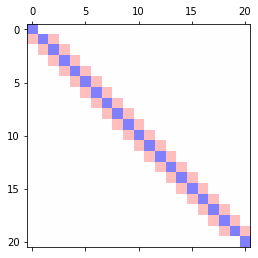

In [4]:
Nx= 20
Nt = 100

T = 10
L = 5

ω = 1.0

xx = np.linspace(0, L, Nx+1)
tt = np.linspace(0, T, Nt+1)

x,t = np.meshgrid(xx,tt)

dx = xx[1] - xx[0]
dt = tt[1] - tt[0]

D = get_D_second_order(Nx+1)
plt.matshow(D, cmap='bwr', vmin=-4, vmax=4) 

In [5]:
u = np.empty((Nt+1,Nx+1))
v = np.empty((Nt+1,Nx+1))  ## v = du/dt 

print(u.shape, v.shape)

# set initial conditions at t=0 for position u(t,x)
u[0,:] = 0

# set initial conditions at t=0 for velocity u'(t,x)
v[0,0] = ω 
v[0,-1] = -ω 
v[0, 1:-1] = 0


## set boundary conditions:
u[:,0] = np.sin(ω * tt)   
u[:,Nx] = - np.sin(ω * tt) 

(101, 21) (101, 21)


In [6]:
## simplectic method

def G(D, u):    
    return np.matmul(D, u) - np.sin(u)


for i in range(0,Nt):
    #for n in range(1,Nx):
        
    tmp = np.empty(Nx+1)
    print("\n\n i = {:} \t t = {:} \t ".format(i, tt[i]))
        
    print("u[i] = {:}".format(u[i, :]))
    print("v[i] = {:}".format(v[i, :]))

    tmp[:] = u[i, :] + 0.5 * v[i, :] * dt 

    print("tmp = {:}".format(tmp))
      
    v[i+1,:] = v[i, :] + G(D, tmp)* dt
        
    print("v[i] = {:}".format(v[i, :]))
    print("v[i+1] = {:}".format(v[i+1, :]))

    u[i+1,:] = tmp + 0.5 * v[i, :]* dt

    print("u[i+1] = {:}".format(u[i+1, :]))





 i = 0 	 t = 0.0 	 
u[i] = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. -0.]
v[i] = [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. -1.]
tmp = [ 0.05  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   -0.05]
v[i] = [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. -1.]
v[i+1] = [ 0.98500208  0.005       0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.005      -0.98500208]
u[i+1] = [ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.1]


 i = 1 	 t = 0.1 	 
u[i] = [ 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.1]
v[i] = [ 0.98500208  0.005       0.          0.          0.          

 -7.93676139e-01]
tmp = [ 6.59686350e-01 -4.60742990e-01 -4.31834220e-01  3.41939052e-02
  6.54480269e-02  1.67944312e-02  2.18913203e-03  1.78127759e-04
  9.92905526e-06  4.00482419e-07 -1.04263152e-24 -4.00482419e-07
 -9.92905526e-06 -1.78127759e-04 -2.18913203e-03 -1.67944312e-02
 -6.54480269e-02 -3.41939052e-02  4.31834220e-01  4.60742990e-01
 -6.59686350e-01]
v[i] = [ 7.93676139e-01  9.51611794e-01 -5.44141022e-01 -2.83328095e-01
  2.53596603e-02  2.63030828e-02  5.21308383e-03  5.49983159e-04
  3.71888016e-05  1.75269723e-06 -9.24947310e-24 -1.75269723e-06
 -3.71888016e-05 -5.49983159e-04 -5.21308383e-03 -2.63030828e-02
 -2.53596603e-02  2.83328095e-01  5.44141022e-01 -9.51611794e-01
 -7.93676139e-01]
v[i+1] = [ 6.00451965e-01  1.11100698e+00 -4.58575352e-01 -3.30224219e-01
  1.08287572e-02  2.80285483e-02  6.25360029e-03  7.16450940e-04
  5.20629091e-05  2.62545803e-06 -2.50270777e-23 -2.62545803e-06
 -5.20629091e-05 -7.16450940e-04 -6.25360029e-03 -2.80285483e-02
 -1.08287572e-

v[i+1] = [-9.54212110e-01  1.20169382e+00  5.91507177e-01 -4.20645706e-01
 -1.70384913e-01  1.26939172e-02  1.48623806e-02  3.24009760e-03
  3.89851389e-04  3.09517047e-05 -1.00091175e-21 -3.09517047e-05
 -3.89851389e-04 -3.24009760e-03 -1.48623806e-02 -1.26939172e-02
  1.70384913e-01  4.20645706e-01 -5.91507177e-01 -1.20169382e+00
  9.54212110e-01]
u[i+1] = [ 6.47678164e-01  5.07843836e-01 -4.95915671e-01 -2.70344119e-01
  2.63188099e-02  3.67189408e-02  9.43460208e-03  1.31037624e-03
  1.18408008e-04  7.55457767e-06 -1.67104315e-22 -7.55457767e-06
 -1.18408008e-04 -1.31037624e-03 -9.43460208e-03 -3.67189408e-02
 -2.63188099e-02  2.70344119e-01  4.95915671e-01 -5.07843836e-01
 -6.47678164e-01]


 i = 50 	 t = 5.0 	 
u[i] = [ 6.47678164e-01  5.07843836e-01 -4.95915671e-01 -2.70344119e-01
  2.63188099e-02  3.67189408e-02  9.43460208e-03  1.31037624e-03
  1.18408008e-04  7.55457767e-06 -1.67104315e-22 -7.55457767e-06
 -1.18408008e-04 -1.31037624e-03 -9.43460208e-03 -3.67189408e-02
 -2.63

 -1.06667685e+00]
v[i] = [-7.65464398e-02  1.94017129e+00 -2.04124484e-01 -1.72105044e+00
  1.12567171e-01  6.26460886e-01  9.28764541e-02 -7.68992453e-02
 -2.95510521e-02 -1.96797611e-03  2.28643252e-20  1.96797611e-03
  2.95510521e-02  7.68992453e-02 -9.28764541e-02 -6.26460886e-01
 -1.12567171e-01  1.72105044e+00  2.04124484e-01 -1.94017129e+00
  7.65464398e-02]
tmp = [ 1.06284953e+00  7.11302253e-02 -1.17873189e+00  4.47039323e-02
  7.23029021e-01  1.50796828e-01 -1.26065422e-01 -6.03052102e-02
 -4.37678508e-03  3.36741246e-03 -1.86949690e-20 -3.36741246e-03
  4.37678508e-03  6.03052102e-02  1.26065422e-01 -1.50796828e-01
 -7.23029021e-01 -4.47039323e-02  1.17873189e+00 -7.11302253e-02
 -1.06284953e+00]
v[i] = [-7.65464398e-02  1.94017129e+00 -2.04124484e-01 -1.72105044e+00
  1.12567171e-01  6.26460886e-01  9.28764541e-02 -7.68992453e-02
 -2.95510521e-02 -1.96797611e-03  2.28643252e-20  1.96797611e-03
  2.95510521e-02  7.68992453e-02 -9.28764541e-02 -6.26460886e-01
 -1.12567171e-01

 -6.65757231e-01]
v[i] = [-1.44325482e+00  1.21804265e+00  1.42748530e+00 -1.48385519e+00
 -9.05055418e-01  5.10072279e-01  3.34100168e-01 -1.89537729e-02
 -4.77472432e-02 -1.14828115e-02  5.86100328e-19  1.14828115e-02
  4.77472432e-02  1.89537729e-02 -3.34100168e-01 -5.10072279e-01
  9.05055418e-01  1.48385519e+00 -1.42748530e+00 -1.21804265e+00
  1.44325482e+00]
v[i+1] = [-1.63817175e+00  9.36472409e-01  1.68608449e+00 -1.28279461e+00
 -1.09664356e+00  4.26189486e-01  3.76566527e-01  2.97682648e-03
 -4.92366566e-02 -1.39676300e-02  7.53120255e-19  1.39676300e-02
  4.92366566e-02 -2.97682648e-03 -3.76566527e-01 -4.26189486e-01
  1.09664356e+00  1.28279461e+00 -1.68608449e+00 -9.36472409e-01
  1.63817175e+00]
u[i+1] = [ 5.93594490e-01  9.74901013e-01 -7.90135919e-01 -8.84047148e-01
  4.82967599e-01  4.79914408e-01 -2.58872053e-03 -8.85748811e-02
 -2.65571185e-02 -3.47997765e-04  1.20934274e-19  3.47997765e-04
  2.65571185e-02  8.85748811e-02  2.58872053e-03 -4.79914408e-01
 -4.8296759

In [7]:
u.shape

(101, 21)

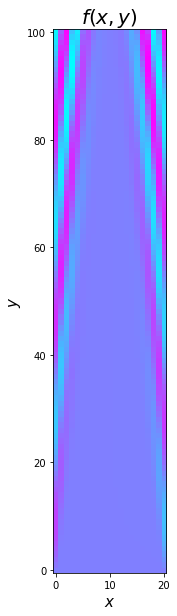

In [13]:
plot_2D(u)

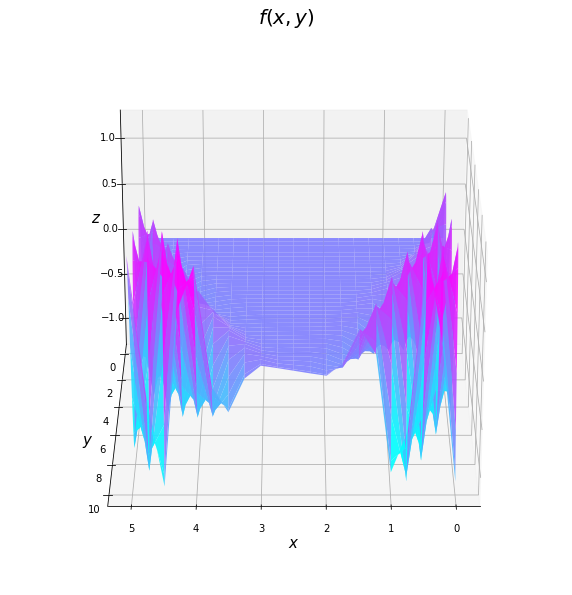

In [12]:
plot_3D(x,t,u, elev=25., azim=90)


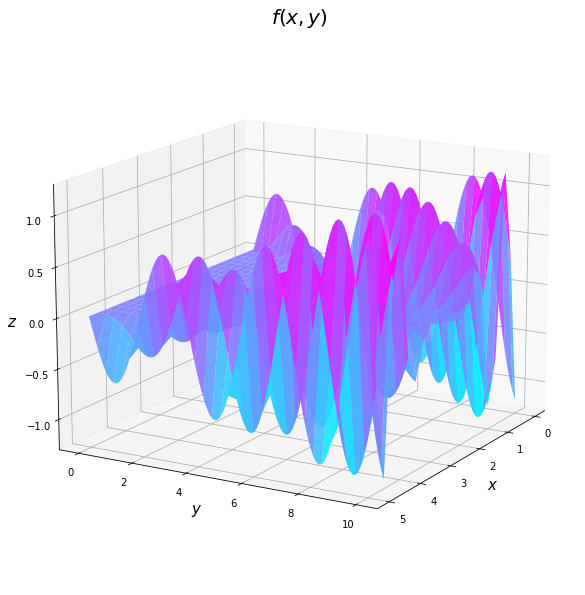

In [11]:
plot_3D(x,t,u, elev=15., azim=30)


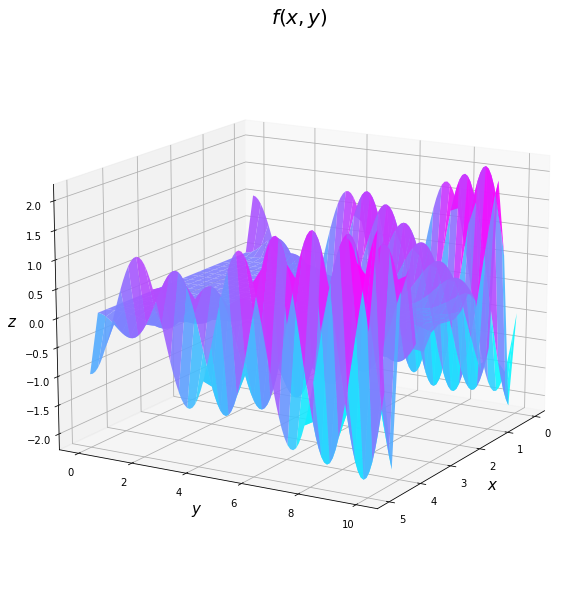

In [10]:
plot_3D(x,t,v, elev=15., azim=30)


### Runge–Kutta–Nyström Methods:

for $$y'' = f(x,y,y')$$ initial value problems $y(x_0) = y_0$, $y'(x_0) = y'_0$  we may use Runge-Kutta-Nyström method:

$$y_{n+1} = y_n + hy'_n + h^2 \sum _{i=0}^m \bar{b}_i k'_i$$

$$y'_{n+1} = y'_n + h \sum _{i=0}^m b_i k'_i$$


$$ k'_i = f(x_n + c_i h, y_n + c_i h y'_n + h^2 \sum _{j=1}^m \bar{a}_{ij} k'_j)$$

$m$  = number of stages


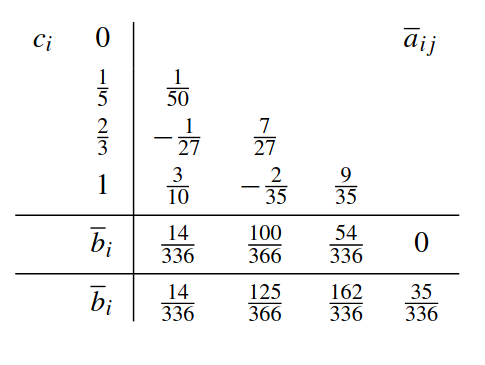